In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os, shutil
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [2]:
csv_path = 'D:\\2k19 new\\train.csv'
df = pd.read_csv(csv_path)
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
base_path = 'D:\\2k19 new\\'
files = os.listdir(base_path + 'images')

In [4]:

    img_list = []
    for i in files[0:20]:
        image = cv2.imread(base_path + "images\\" + i)
        image = cv2.resize(src=image, dsize=(400, 400))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_list.append(image)
    len(img_list)

20

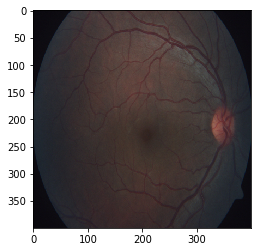

In [5]:
plt.imshow(img_list[6]);

In [6]:
#For applying CLAHE, the image should be in LAB format
lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
lab.shape


(400, 400, 3)

In [7]:
#Splitting the lab to reach L layers
l, a, b = cv2.split(lab)


shape: (400, 400)


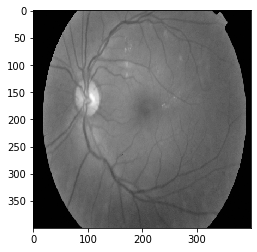

In [8]:
#showing L layer
plt.imshow(l, cmap = "gray")
print("shape:", l.shape) #2D #It has two sizes now


In [9]:
flatten = l.flatten()
flatten.shape

(160000,)

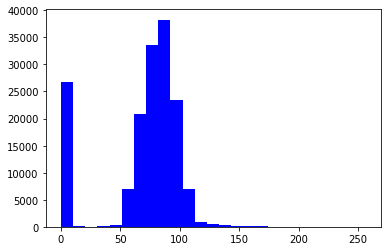

In [10]:
#Showing their histograms
#asymmetric distribution
plt.hist(flatten, 25, [0,256], color="b")
plt.show()

In [11]:
#Applying CLAHE(contrast enhancement)
clahe = cv2.createCLAHE(clipLimit = 7, tileGridSize=(8,8))
cl = clahe.apply(l) + 10

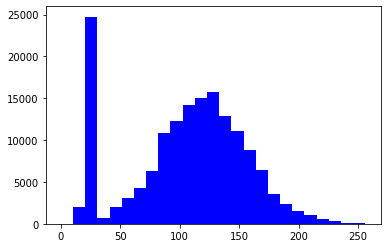

In [12]:
plt.hist(cl.flatten(), 25, [0,256], color="b")
plt.show()

In [13]:
merge = cv2.merge((cl, a, b))

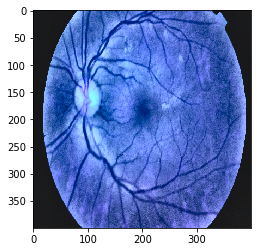

In [14]:
img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)

plt.imshow(img);

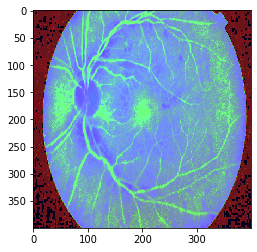

In [15]:
final_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(final_img);

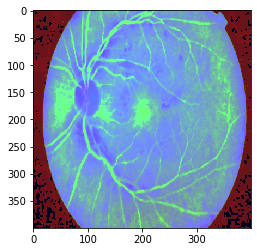

In [16]:
#Blurring operation to remove noise
med_blur = cv2.medianBlur(final_img, ksize=3)
plt.imshow(med_blur);

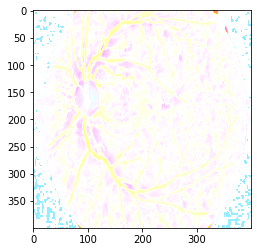

In [17]:
back_ground = cv2.medianBlur(final_img, ksize=35)
mask = cv2.addWeighted(med_blur, 1, back_ground, -1, 255)
plt.imshow(mask);

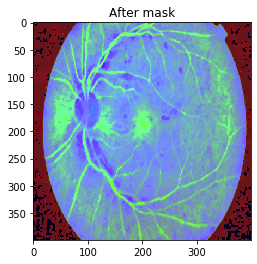

In [18]:
#applying mask
final_mask = cv2.bitwise_and(mask, med_blur)
plt.title("After mask")
plt.imshow(final_mask);

In [5]:
def preprocessing(files):
    #This function returns images prepared for training

    img_list = []
    for i in tqdm(files):
        image = cv2.imread(base_path + 'images\\' + i)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        copy = image.copy()
        copy = cv2.cvtColor(copy, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(copy, (5, 5), 0)
        
        thresh = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)[1]
        
        # CONTOUR DETECTION
        contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = contour[0][0]
        contour = contour[:, 0, :]

        # GET COORDINATES
        x1 = tuple(contour[contour[:, 0].argmin()])[0]
        y1 = tuple(contour[contour[:, 1].argmin()])[1]
        x2 = tuple(contour[contour[:, 0].argmax()])[0]
        y2 = tuple(contour[contour[:, 1].argmax()])[1]

        #Crop Images Again to Destroy Black Area
        x = int(x2 - x1) * 4 // 50
        y = int(y2 - y1) * 5 // 50

        # THRES FOR CROPPED IMAGES
        copy2 = image.copy()
        if x2 - x1 > 100 and y2 - y1 > 100:
            copy2 = copy2[y1 + y: y2 - y, x1 + x: x2 - x]
            copy2 = cv2.resize(copy2, (224, 224))

        # LAB
        lab = cv2.cvtColor(copy2, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)

        #Applying CLAHE(contrast enhancement)
        clahe = cv2.createCLAHE(clipLimit = 7, tileGridSize=(8,8))
        cl = clahe.apply(l) + 10

        # MERGING LAB
        merge = cv2.merge((cl, a, b))
        img = cv2.cvtColor(merge, cv2.COLOR_LAB2RGB)
        final_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        med_blur = cv2.medianBlur(final_img, 3)
        back_gorund = cv2.medianBlur(final_img, 35)

        # MASK FOR BLEEDING VEIN
        mask = cv2.addWeighted(med_blur, 1, back_gorund, -1, 255)
        final = cv2.bitwise_and(mask, med_blur)
        img_list.append(final)

    return img_list


img_list = preprocessing(files=files)

100%|██████████████████████████████████████████████████████████████████████████████| 3662/3662 [02:52<00:00, 21.27it/s]


In [6]:
target = df["diagnosis"]
target[:10]

0    2
1    4
2    1
3    0
4    0
5    4
6    0
7    2
8    2
9    1
Name: diagnosis, dtype: int64

In [7]:
# train_path = 'D:\\data2019\\train_images'
# test_path = 'D:\\data2019\\test_images'

In [8]:
# train_df = pd.read_csv('D:\\data2019\\train.csv')
# test_df = pd.read_csv('D:\\data2019\\test.csv')
# print(train_df.shape)
# print(test_df.shape)
# train_df.head()

In [9]:
# N = train_df.shape[0]
# x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

In [10]:
# N = test_df.shape[0]
# x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

In [11]:
y_train = pd.get_dummies(df['diagnosis']).values
#x_train = np.array(img_list)
#print(x_train.shape)
y_train
#print(x_test.shape)

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

# Converting to Multi-Label

In [12]:
y_train_multi = np.empty(y_train.shape, dtype = y_train.dtype)
y_train_multi[:,4] = y_train[:,4]

for i in range(3,-1,-1):
    y_train_multi[:,i] = np.logical_or(y_train[:,i], y_train_multi[:,i+1])
y_train_multi 
# print("original:", y_train.sum(axis=0))
# print("multilabel:", y_train_multi.sum(axis=0))

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint8)

In [13]:
# y_train = pd.get_dummies(df["diagnosis"]).values
# y_train[:10]

In [14]:
# y_train_final = np.zeros((5,3), dtype=np.int)
# y_train_final = y_train[:,4]
# y_train_final

# Image to Array

In [15]:
x_train = np.array(img_list)
x_train.shape

(3662, 224, 224, 3)

In [16]:
x_train.shape[2]

224

In [17]:
# x_train=np.reshape(x_train,(x_train.shape[0], 240, 240,3))
# x_train.shape

In [18]:
#y_train= df["diagnosis"][1:2031]
#y_train_multi[1:2031]
y_train_multi.shape

(3662, 5)

# Data splitting

In [19]:
#Splitting of dataset
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train_multi, 
                                                  test_size = 0.3, random_state = 100)


In [20]:
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (2563, 224, 224, 3)
X_val: (1099, 224, 224, 3)
y_train: (2563, 5)
y_val: (1099, 5)


In [21]:
# y_train= df["diagnosis"][1:2031]
# y_train.shape

In [22]:
# from keras.preprocessing.image import ImageDataGenerator
# BATCH_SIZE = 32

# def create_datagen():
#     return ImageDataGenerator(
#             zoom_range=0.15,
#             horizontal_flip=True,
#             vertical_flip=True,
#              fill_mode='constant',
#              cval=0.1
#                      )
# data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE)
# mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())

In [23]:
# true_labels = np.array([1, 0, 1, 1, 0, 1])
# pred_labels = np.array([1, 0, 0, 0, 0, 1])

In [24]:
# from sklearn.metrics import cohen_kappa_score, accuracy_score
# accuracy_score(true_labels, pred_labels)

In [25]:
# cohen_kappa_score(true_labels, pred_labels)

In [26]:
datagen = ImageDataGenerator(horizontal_flip=True,
                            vertical_flip=True,
                            zoom_range=0.3,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            fill_mode='constant',
                            cval=0.1)
datagen_valid = ImageDataGenerator(fill_mode='constant')
batch_size = 64
data_generator = datagen.flow(X_train,
                             y_train,
                             batch_size = 64,
                             seed=42)
                             
validation_generator = datagen_valid.flow(X_val,
                             y_val,
                             batch_size = 64,
                             seed=42)    

In [27]:

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
#def build_model():
    
model = tf.keras.Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(224,224,3))) #activation="relu"
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
# model.add(BatchNormalization())
model.add(Flatten())
#Fully connected layer
model.add(Dense(128))   #kernel_constraint=max_norm(3)
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(64)) 
model.add(LeakyReLU(alpha=0.1))

#output layer
#for binary classification
model.add(Dense(units = 5 , kernel_regularizer=tf.keras.regularizers.l2(0.01), activation = 'softmax'))


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0

In [31]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# #create the base pre-trained model
# conv_base = InceptionV3(weights="imagenet", include_top = False, input_shape = (299, 299, 3))
# conv_base.summary()

In [29]:
model.compile(loss='binary_crossentropy',
             optimizer=keras.optimizers.Adam(lr=0.0003), #"rmsprop"
             metrics=['accuracy'])

In [30]:
# from tensorflow.keras.callbacks import EarlyStopping
# lr = EarlyStopping(monitor = 'val_loss',
#                       patience = 2,
#                       verbose = 1,
#                       mode = 'auto',
#                       baseline=None,
#                       restore_best_weights=False
#                       )

In [31]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

early = EarlyStopping(monitor = 'val_loss', patience=6)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                      patience = 3,
                      verbose = 1,
                      mode = 'auto',
                      factor = 0.25,
                      min_lr=0.0001)
callbacks_list = [early, lr]

In [32]:
# y_train = np.asarray(X_val).astype('float32').reshape((-1,1))
# y_test = np.asarray(y_val).astype('float32').reshape((-1,1))

In [33]:

#import sklearn.metrics as metrics
#kappa_metrics = Metrics()
history = model.fit(
        data_generator,
        steps_per_epoch= X_train.shape[0]//batch_size, #data_generator.n//batch_size,
        epochs=5,
        validation_data = validation_generator, #(X_val, y_val)
        validation_steps =  validation_generator.n// batch_size,        #len(X_val) 

        callbacks = callbacks_list)

Epoch 1/5
40/40 [==============================] - ETA: 4:37 - loss: 127.8815 - accuracy: 0.53 - ETA: 2:23 - loss: 108.9268 - accuracy: 0.63 - ETA: 2:20 - loss: 98.2443 - accuracy: 0.6875 - ETA: 2:16 - loss: 90.3114 - accuracy: 0.714 - ETA: 2:14 - loss: 85.4190 - accuracy: 0.735 - ETA: 2:11 - loss: 81.5335 - accuracy: 0.753 - ETA: 2:07 - loss: 78.3286 - accuracy: 0.769 - ETA: 2:02 - loss: 75.6035 - accuracy: 0.783 - ETA: 1:58 - loss: 73.2062 - accuracy: 0.796 - ETA: 1:54 - loss: 70.9948 - accuracy: 0.807 - ETA: 1:50 - loss: 68.9197 - accuracy: 0.816 - ETA: 1:46 - loss: 66.9724 - accuracy: 0.825 - ETA: 1:42 - loss: 65.1514 - accuracy: 0.833 - ETA: 1:38 - loss: 63.4525 - accuracy: 0.840 - ETA: 1:34 - loss: 61.8726 - accuracy: 0.846 - ETA: 1:30 - loss: 60.3971 - accuracy: 0.852 - ETA: 1:26 - loss: 59.0051 - accuracy: 0.857 - ETA: 1:22 - loss: 57.6886 - accuracy: 0.862 - ETA: 1:18 - loss: 56.4445 - accuracy: 0.866 - ETA: 1:14 - loss: 55.2689 - accuracy: 0.870 - ETA: 1:07 - loss: 54.2031 - 

In [35]:
test_eval = model.evaluate(X_val, y_val, verbose=0)


In [36]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.7426735758781433
Test accuracy: 0.9162875413894653


In [37]:
model.save('retinopathy.h5')

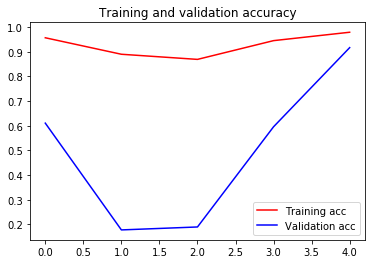

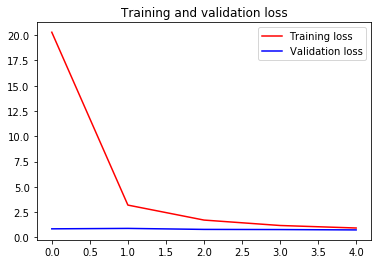

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()